In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import optuna

## Consolidate Data

In [2]:
df_train = pd.read_csv(r"/kaggle/input/store-sales-time-series-forecasting/train.csv", index_col=0)
df_test = pd.read_csv(r"/kaggle/input/store-sales-time-series-forecasting/test.csv", index_col=0)
df_transactions = pd.read_csv(r"/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
df_stores = pd.read_csv(r"/kaggle/input/store-sales-time-series-forecasting/stores.csv")
df_holidays = pd.read_csv(r"/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
df_oil = pd.read_csv(r"/kaggle/input/store-sales-time-series-forecasting/oil.csv")

In [3]:
df_oil['date'] = df_oil['date'].astype("datetime64")
df_date = pd.DataFrame(pd.date_range("2013-01-01", "2017-08-31"), columns=["date"])
df_oil = df_date.merge(df_oil, left_on='date', right_on='date', how='left').fillna(method='ffill').fillna(method='bfill')
df = pd.concat([df_train, df_test], ignore_index=True)
df = df.merge(df_stores, left_on="store_nbr", right_on="store_nbr", how="left")
df_holidays = df_holidays.rename(columns={"type": "Holiday_type"})
df = df.merge(df_holidays, left_on="date", right_on="date", how="left")
df = df.merge(df_transactions, left_on=["date", "store_nbr"], right_on=["date", "store_nbr"], how="left")
df["date"] = df["date"].astype("datetime64")
df = df.merge(df_oil, left_on="date", right_on="date", how="left")
df = df.replace(",", "_", regex=True)
df = df.rename(columns={"date": "Date"})

## Feature Engineering & Cleanup

In [4]:
def categorical_features(df):
    df['month'] = df.Date.dt.month.astype('category')
    df['day_of_month'] = df.Date.dt.day.astype('category')
    df['day_of_year'] = df.Date.dt.dayofyear.astype('category')
    df['week_of_year'] = df.Date.dt.isocalendar().week.astype('category')
    df['day_of_week'] = df.Date.dt.dayofweek.astype('category')
    df['year'] = df.Date.dt.year.astype('category')

    categorical_features = ['store_nbr', 'onpromotion', 'cluster']
    for col in categorical_features:
        df[col] = df[col].astype('category')

    return df

In [5]:
LAGS = list(range(16, 23))

In [6]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe[f'sales_lag({lag})'] =\
            dataframe.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(lag))
    for lag in lags:
        dataframe[f'oil_lag({lag})'] =\
            dataframe.groupby(['store_nbr', 'family'])['dcoilwtico'].transform(lambda x: x.shift(lag))
    return dataframe

In [7]:
df = categorical_features(df)
df = lag_features(df, LAGS)
df = df.fillna(value=np.nan)

In [8]:
categorical = df.columns[df.dtypes == 'object'].tolist()
numerical = df.columns[(df.dtypes == 'int64') | (df.dtypes == 'float64') | ( df.dtypes == 'UInt32')].tolist()
for col in categorical:
    df[col] = df[col].astype('category')
for col in numerical:
    df[col] = df[col].fillna(0)
    df[col] = df[col].astype('float32')

## Exploratory Data Analysis

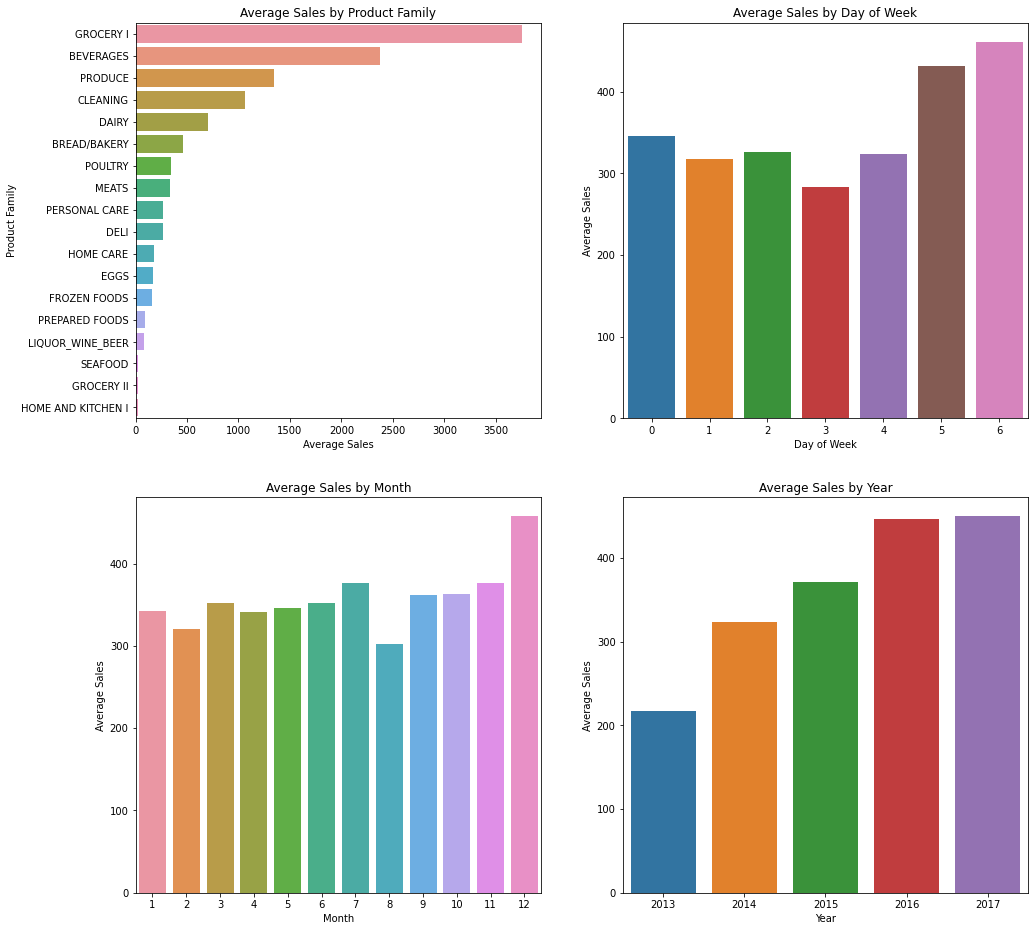

In [9]:
plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
_ = df.groupby('family')['sales'].mean().sort_values(ascending = False).head(18).to_frame()
sns.barplot(data = _, x = _.sales, y = _.index, ci = None, order = list(_.index))
plt.xlabel('Average Sales')
plt.ylabel('Product Family')
plt.title('Average Sales by Product Family')

plt.subplot(2,2,2)
_ = df.groupby('day_of_week')['sales'].mean().to_frame()
sns.barplot(data=_, y=_.sales, x=_.index, ci=None, order=list(_.index))
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.title('Average Sales by Day of Week')

plt.subplot(2,2,3)
_ = df.groupby('month')['sales'].mean().to_frame()
sns.barplot(data=_, y=_.sales, x=_.index, ci=None, order=list(_.index))
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Average Sales by Month')

plt.subplot(2,2,4)
_ = df.groupby('year')['sales'].mean().to_frame()
sns.barplot(data=_, y=_.sales, x=_.index, ci=None, order=list(_.index))
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.title('Average Sales by Year')

plt.show()

## Train, Validation & Test Split

In [10]:
TRAIN_START = '2016-01-01'
DROP_FEATURES = ['Date', 'transferred', 'locale_name', 'description']

In [11]:
train = df[(df['Date'] >= TRAIN_START) & (df['Date'] < '2017-08-01')]
validation = df.query("Date >= '2017-08-01' & Date <= '2017-08-15'")
test = df.query("Date > '2017-08-15'")
df = df.drop(DROP_FEATURES, axis=1)

In [12]:
TARGET = 'sales'
FEATURES = list(df.columns.difference([TARGET]))

In [13]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_validation = validation[FEATURES]
y_validation = validation[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
d_train = xgb.DMatrix(data = X_train, label = y_train, enable_categorical = True)
d_validation = xgb.DMatrix(data = X_validation, label = y_validation, enable_categorical = True)
d_test = xgb.DMatrix(data = X_test, label = y_test, enable_categorical = True)

## Define Parameter Search Space & Run Optuna Study

In [15]:
NUM_TRIALS = 20
EARLY_STOP = 10

In [16]:
def objective(n_trials):
    params = {
        'objective': 'reg:squarederror',
        'max_depth' : n_trials.suggest_int('max_depth', 1, 18),
        'n_estimators' : n_trials.suggest_int('n_estimators', 10, 1000, step = 10),
        'learning_rate': n_trials.suggest_float('learning_rate', 0.005, 0.5),
        'colsample_bytree': n_trials.suggest_float('colsample_bytree', 0.1, 0.6),
        'min_child_weight' : n_trials.suggest_int('min_child_weight', 0, 10),
        'subsample': n_trials.suggest_float('subsample', 0.1, 1),
        'reg_alpha' : n_trials.suggest_int('reg_alpha', 40, 180),
        'reg_lambda' : n_trials.suggest_int('reg_lambda', 0, 1),
        'gamma': n_trials.suggest_float('lambda', 1, 10)
    }
    xgb_regressor = xgb.train(params, d_train,
                    evals = [(d_validation, 'eval'), (d_train, 'train')],
                    early_stopping_rounds = EARLY_STOP,
                    verbose_eval = False)
    y_pred = xgb_regressor.predict(d_validation)
    mse = mean_squared_error(y_validation, y_pred)
    return mse

In [17]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = NUM_TRIALS)

[21:21:57] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:22:10] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:22:18] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being use

In [18]:
print('Best params:')
for key, value in study.best_params.items():
    print(f'\t{key}: {value}')

Best params:
	max_depth: 16
	n_estimators: 100
	learning_rate: 0.45247149449532525
	colsample_bytree: 0.37747111552607926
	min_child_weight: 10
	subsample: 0.9759002722665786
	reg_alpha: 82
	reg_lambda: 0
	lambda: 1.7951226431503415


## Train Model & Make Predictions

In [19]:
xgb_regressor = xgb.train(study.best_params, d_train,
                evals =[(d_validation, 'eval'), (d_train, 'train')],
                early_stopping_rounds = 3,
                verbose_eval = False)

[21:26:30] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




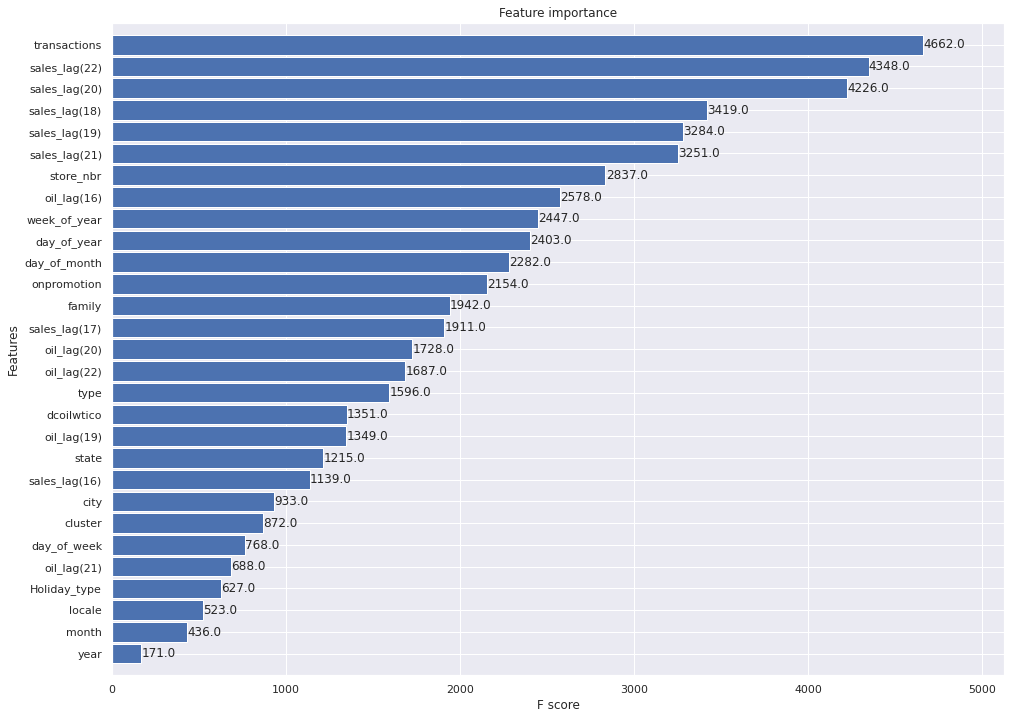

In [20]:
sns.set(rc = {'figure.figsize':(16, 12)})
_ = xgb.plot_importance(xgb_regressor, height=0.9)

In [21]:
val_predicted = xgb_regressor.predict(d_validation).tolist()
val_true = y_validation.tolist()

In [22]:
results = pd.DataFrame({'prediction':val_predicted, 'actual': val_true})
results[results < 0] = 0

In [23]:
mean_squared_log_error(results['actual'], results['prediction'], squared=False)

0.4793574512168299

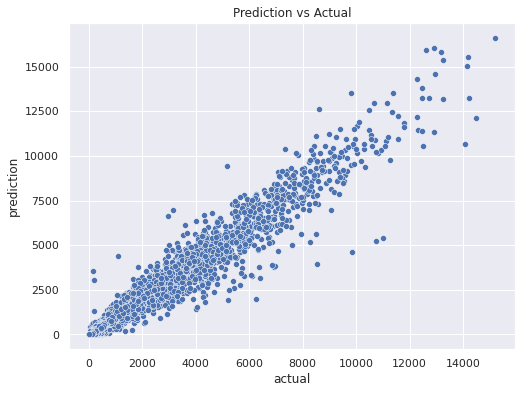

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results, y=results.prediction, x=results.actual)
plt.title('Prediction vs Actual')
plt.show()

In [25]:
results

,prediction,actual
0,5.987432,5.000000
1,0.000000,0.000000
2,4.975935,4.000000
3,2975.464355,2627.000000
4,0.303205,0.000000
...,...,...
26725,348.856842,438.132996
26726,86.371033,154.552994
26727,2482.669678,2419.729004
26728,36.136318,121.000000


In [26]:
submission = pd.read_csv(r"./data/sample_submission.csv")
y_test = xgb_regressor.predict(d_test)
y_test[y_test < 0] = 0
submission['sales'] = y_test
submission.to_csv("submission.csv", index=False)
submission.head()

FileNotFoundError: [Errno 2] No such file or directory: './data/sample_submission.csv'